In [1]:
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import Timeline, Radar, Sankey
from pyecharts import options as opts
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

### 数据抓取，基本无反爬，但仍然间隔1s

注：若不想等待抓取过程，可直接运行后面本地读取文件结果

In [8]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36',
    'Referer': 'http://2020.pesdb.cn/',
    'Host': 'api.pesdb.cn'
}
for page in range(1, 753):
    print('current page: ', page)
    url = f'http://api.pesdb.cn/api/pc/Players/{page}'
    jsons = requests.get(url, headers=headers).json()
    infos = []
    for result in jsons['result']:
        ## 球员基本属性
        name = result['playerName']  # 姓名
        age = result['age']  # 年龄
        height = result['height']  # 身高 
        weight = result['weight']  # 体重
        footId = result['footId']  # 惯用脚
        region = result['regionName']  # 大洲
        nation = result['nationalityName']  # 国籍
        league = result['leagueName']  # 联赛
        team = result['teamName']  # 球队
        position = result['positionName']  # 位置
        starLevel = result['starLevel']  # 星级
        rating = result['overallRating']  # 总评分
        offensiveAwareness = result['offensiveAwareness']  # 进攻能力
        finishing = result['finishing']  # 射门
        header = result['header']  # 头球
        aggression = result['aggression']  # 积极性
        speed = result['speed']  # 速度
        ballControl = result['ballControl']  # 控球
        lowPass = result['lowPass']  # 地面传球
        catching = result['catching']  # 接球 ： 门将
        dribbling = result['dribbling']  # 盘带
        placeKicking = result['placeKicking']  # 定位球
        loftedPass = result['loftedPass']  # 空中传球
        acceleration = result['acceleration']  # 爆发力
        kickingPower = result['kickingPower']  # 脚下力量
        defensiveAwareness = result['defensiveAwareness']  # 防守能力
        ballWinning = result['ballWinning']  # 抢断
        clearing = result['clearing']  # 解围
        gkAwareness = result['gkAwareness']  # 守门能力
        reflexes = result['reflexes']  # 扑救反应
        stamina = result['stamina']  # 耐力
        balance = result['balance']  # 协调性
        jump = result['jump']  # 跳跃
        reach = result['reach']  # 覆盖区域
        injuryResistance = result['injuryResistance']  # 抗受伤程度
        physicalContact = result['physicalContact']  # 身体接触
        # 信息汇总
        info = [name, age, height, weight, footId, region, nation, league, team, position, starLevel, rating, offensiveAwareness, finishing,
                header, aggression, speed, ballControl, lowPass, catching, dribbling, placeKicking, loftedPass, acceleration, kickingPower,
                defensiveAwareness, ballWinning, clearing, gkAwareness, reflexes, stamina, balance, jump, reach, injuryResistance, physicalContact]
        infos.append(info)
    df = pd.DataFrame(infos)
    time.sleep(1)

df.columns = ['name', 'age', 'height', 'weight', 'footId', 'region', 'nation', 'league', 'team', 'position', 
           'starLevel', 'rating', 'offensiveAwareness', 'finishing', 'header', 'aggression', 'speed', 'ballControl',
           'lowPass', 'catching', 'dribbling', 'placeKicking', 'loftedPass', 'acceleration', 'kickingPower',
           'defensiveAwareness', 'ballWinning', 'clearing', 'gkAwareness', 'reflexes', 'stamina', 'balance', 
           'jump', 'reach', 'injuryResistance', 'physicalContact']
df.reset_index(drop=True, inplace=True)
df.to_csv('PES2020.csv', index=False) # 保存至本地

## 数据分析与可视化
本地直接读取已有数据文件

In [3]:
df = pd.read_csv('PES2020.csv')
df.head()

- 数据质量很高，但为了数据可读性，将一些知名联赛和俱乐部名字做以更改
- 同时，数据库有个错别字，"影锋"写成了"影峰"
- 构造体型BMI数据

In [9]:
df['league'].replace('Serie A TIM', '意甲', inplace=True)
df['league'].replace('西班牙联赛', '西甲', inplace=True)
df['league'].replace('英格兰联赛', '英超', inplace=True)
df['league'].replace('Ligue 1 Conforama', '法甲', inplace=True)
df['league'].replace('中国足球协会超级联赛', '中超', inplace=True)
df['team'].replace('马德里查马丁 白', '皇家马德里', inplace=True)
df['team'].replace('马德里罗萨斯 红白', '马德里竞技', inplace=True)
df['team'].replace('曼彻斯特 蓝', '曼城', inplace=True)
df['team'].replace('曼彻斯特 红', '曼联', inplace=True)
df['position'].replace('影峰', '影锋', inplace=True)
df['BMI'] = df['weight'] / df['height']**2 * 10000  # BMI:体重/身高^2，体重：KG，身高：m

In [10]:
def get_positionLevel(position):
    if position in ['影锋', '中锋', '左边锋', '右边锋']:
        return '前场'
    elif position in ['前腰', '后腰', '左前卫', '右前卫', '中前卫'] :
        return '中场'
    elif position in ['左后卫', '右后卫', '中后卫']:
        return '后场'
    else:
        return '门将'
        
df['posLevel'] = df['position'].apply(get_positionLevel)

In [11]:
df.head(10)

,name,age,height,weight,footId,region,nation,league,team,position,...,gkAwareness,reflexes,stamina,balance,jump,reach,injuryResistance,physicalContact,posLevel,BMI
0,利昂内尔·梅西,32,170,72,2,南美洲,阿根廷,西甲,巴塞罗那,右边锋,...,40,40,84,93,65,40,3,70,前场,24.913495
1,克里斯蒂亚诺·罗纳尔多,34,187,83,1,欧洲,葡萄牙,意甲,尤文图斯,左边锋,...,40,40,84,84,97,40,3,86,前场,23.735308
2,内马尔·达席尔瓦,27,175,68,1,南美洲,巴西,法甲,巴黎圣日耳曼,左边锋,...,40,40,82,91,66,40,1,63,前场,22.204082
3,维吉尔·范迪克,28,193,92,1,欧洲,荷兰,英超,利物浦 红,中后卫,...,40,40,85,65,89,40,3,94,后场,24.698650
4,路易斯·苏亚雷斯,32,182,86,1,南美洲,乌拉圭,西甲,巴塞罗那,中锋,...,40,40,82,89,75,40,2,87,前场,25.963048
5,罗伯特·莱万多夫斯基,31,185,79,1,欧洲,波兰,其他欧洲球队,拜仁慕尼黑,中锋,...,40,40,79,82,89,40,3,84,前场,23.082542
6,埃登·阿扎尔,28,173,76,1,欧洲,比利时,西甲,皇家马德里,左边锋,...,40,40,80,95,58,40,2,70,前场,25.393431
7,塞尔希奥·阿圭罗,31,173,70,1,南美洲,阿根廷,英超,曼城,中锋,...,40,40,79,88,83,40,2,74,前场,23.388687
8,穆罕默德·萨拉赫,27,175,71,2,非洲,埃及,英超,利物浦 红,右边锋,...,40,40,84,90,68,40,2,69,前场,23.183673
9,扬·奥布拉克,26,188,87,1,欧洲,斯洛文尼亚,西甲,马德里竞技,守门员,...,97,97,65,70,86,95,3,87,门将,24.615211


### 一、分布
#### 球队级
- 各大洲
- 各国家
- 各俱乐部人数分布
- 各俱乐部球员评分均值分布

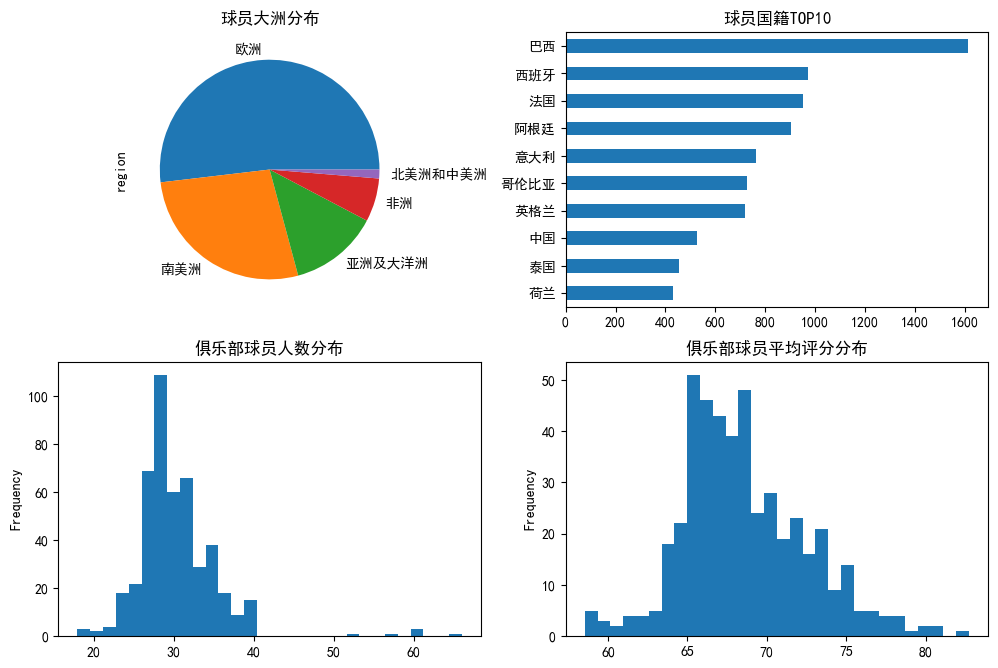

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=100)
df['region'].value_counts().plot(kind='pie', ax=axes[0, 0], title='球员大洲分布')
df['nation'].value_counts(ascending=True)[-10:].plot(kind='barh', ax=axes[0, 1], title='球员国籍TOP10')
df.query('team!="自由球员"').groupby('team')['name'].count().plot(kind='hist', bins=30, ax=axes[1, 0], title='俱乐部球员人数分布')
df.query('team!="自由球员"').groupby('team')['rating'].mean().plot(kind='hist', bins=30, ax=axes[1, 1], title='俱乐部球员平均评分分布')
plt.savefig('球队画像.png')

#### 球员级
- 年龄分布
- BMI分布
- 星级分布
- 总评分分布
- 惯用脚比例
- 位置分布

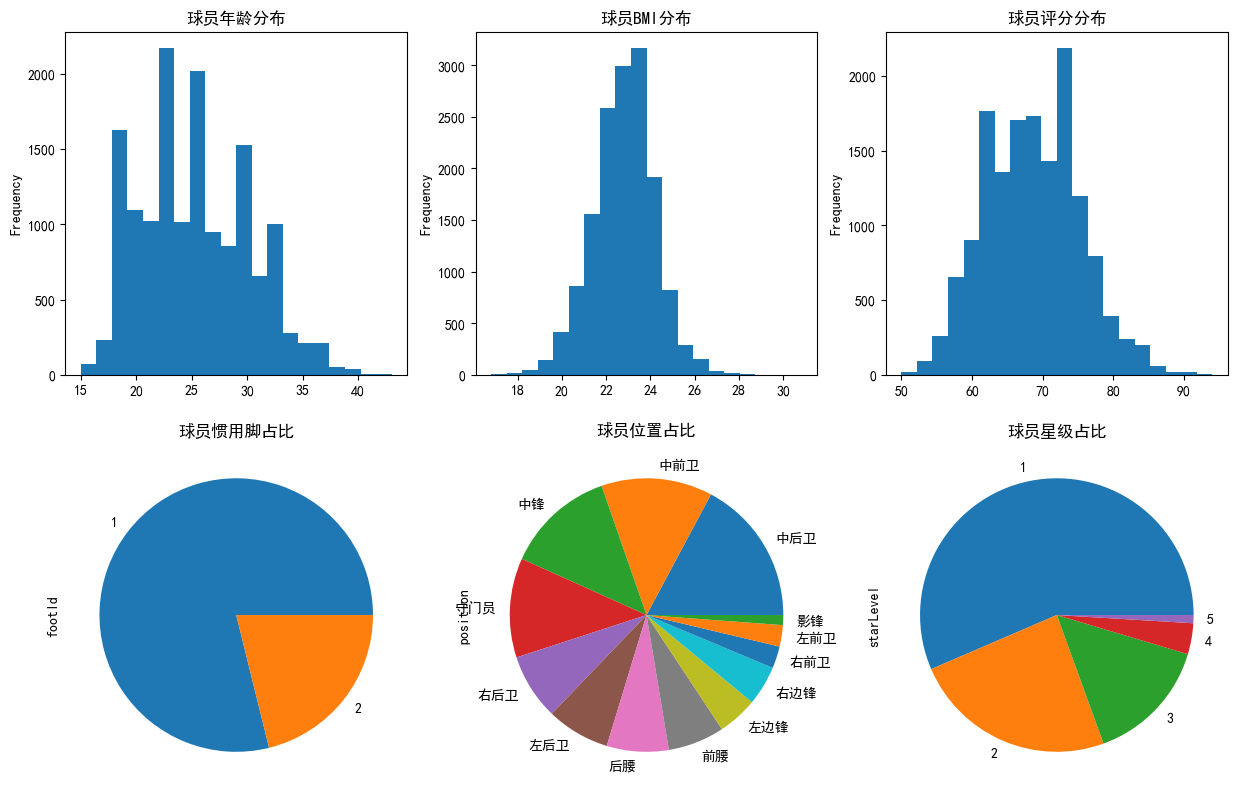

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)
df['age'].plot(kind='hist', bins=20, ax=axes[0, 0], title='球员年龄分布')
df['BMI'].plot(kind='hist', bins=20, ax=axes[0, 1], title='球员BMI分布')
df['rating'].plot(kind='hist', ax=axes[0, 2], bins=20, title='球员评分分布')
df['footId'].value_counts().plot(kind='pie', ax=axes[1, 0], title='球员惯用脚占比')
df['position'].value_counts().plot(kind='pie', ax=axes[1, 1], title='球员位置占比')
df['starLevel'].value_counts().plot(kind='pie', ax=axes[1, 2], title='球员星级占比')
plt.savefig('球员画像.png')

- 制作主流联赛球员来源桑基图(若用3层模型，则因节点过多而效果较差)

In [14]:
leagues = ['英超', '西甲', '法甲', '意甲', '其他欧洲球队', '中超']
df_league = df[df['league'].isin(leagues)]

nodes = []
for name in df_league['region'].unique().tolist() + df_league['league'].unique().tolist():
    nodes.append({'name': name})

temp = df_league.groupby(['region', 'league'])['name'].count().reset_index()
temp.columns = ['source','target','value']
links = [{'source': i[0], 'target':i[1], 'value':i[2]} for i in temp.values]

sankey = (
    Sankey().add('',
             nodes,
             links,
             linestyle_opt=opts.LineStyleOpts(opacity=0.3, curve=0.5, color='source'),
             label_opts=opts.LabelOpts(position='top'),
             node_gap = 30,
        )
        .set_global_opts(title_opts=opts.TitleOpts(title = '六大联赛球员来源图'))
)
sankey.render('六大联赛.html')

'D:\\JupyterFile\\mytest\\六大联赛.html'

- 几个可能相关性较大的特征

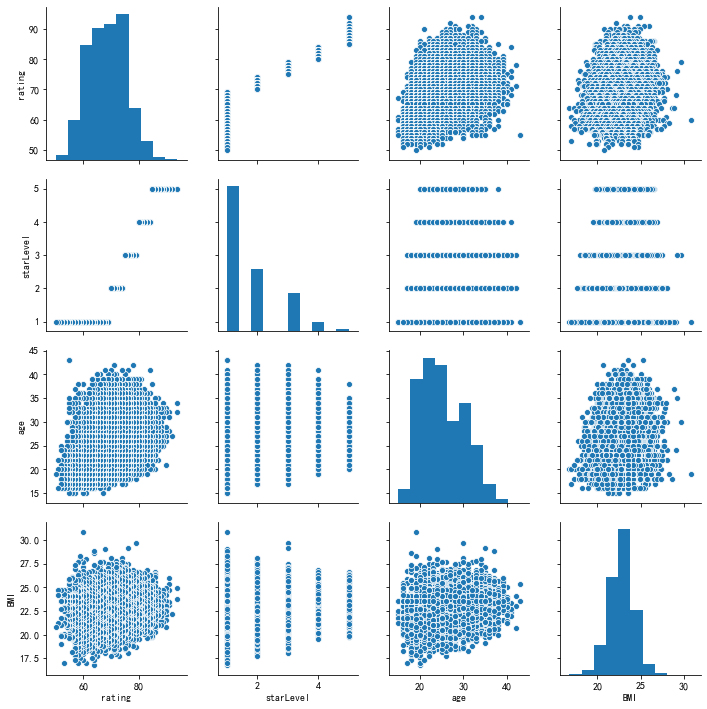

In [15]:
sns.pairplot(df[['rating', 'starLevel', 'age', 'BMI']])

- 不同联赛球员评分

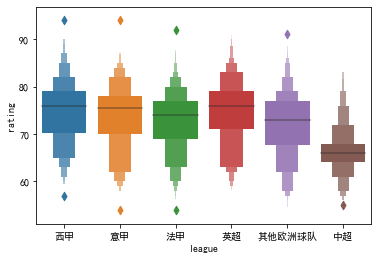

In [16]:
sns.boxenplot(x='league', y='rating', data=df[df['league'].isin(leagues)])
plt.savefig('六大联赛球员评分')

### 二、细分
- 10大超巨

In [17]:
df.sort_values('rating', ascending=False).head(8)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel
0,利昂内尔·梅西,32,170,72,南美洲,阿根廷,西甲,巴塞罗那,右边锋,94,5
1,克里斯蒂亚诺·罗纳尔多,34,187,83,欧洲,葡萄牙,意甲,尤文图斯,左边锋,94,5
2,内马尔·达席尔瓦,27,175,68,南美洲,巴西,法甲,巴黎圣日耳曼,左边锋,92,5
3,维吉尔·范迪克,28,193,92,欧洲,荷兰,英超,利物浦 红,中后卫,91,5
4,路易斯·苏亚雷斯,32,182,86,南美洲,乌拉圭,西甲,巴塞罗那,中锋,91,5
5,罗伯特·莱万多夫斯基,31,185,79,欧洲,波兰,其他欧洲球队,拜仁慕尼黑,中锋,91,5
6,埃登·阿扎尔,28,173,76,欧洲,比利时,西甲,皇家马德里,左边锋,91,5
7,塞尔希奥·阿圭罗,31,173,70,南美洲,阿根廷,英超,曼城,中锋,91,5


In [19]:
df.query('rating>90')

,name,age,height,weight,footId,region,nation,league,team,position,...,gkAwareness,reflexes,stamina,balance,jump,reach,injuryResistance,physicalContact,posLevel,BMI
0,利昂内尔·梅西,32,170,72,2,南美洲,阿根廷,西甲,巴塞罗那,右边锋,...,40,40,84,93,65,40,3,70,前场,24.913495
1,克里斯蒂亚诺·罗纳尔多,34,187,83,1,欧洲,葡萄牙,意甲,尤文图斯,左边锋,...,40,40,84,84,97,40,3,86,前场,23.735308
2,内马尔·达席尔瓦,27,175,68,1,南美洲,巴西,法甲,巴黎圣日耳曼,左边锋,...,40,40,82,91,66,40,1,63,前场,22.204082
3,维吉尔·范迪克,28,193,92,1,欧洲,荷兰,英超,利物浦 红,中后卫,...,40,40,85,65,89,40,3,94,后场,24.698650
4,路易斯·苏亚雷斯,32,182,86,1,南美洲,乌拉圭,西甲,巴塞罗那,中锋,...,40,40,82,89,75,40,2,87,前场,25.963048
5,罗伯特·莱万多夫斯基,31,185,79,1,欧洲,波兰,其他欧洲球队,拜仁慕尼黑,中锋,...,40,40,79,82,89,40,3,84,前场,23.082542
6,埃登·阿扎尔,28,173,76,1,欧洲,比利时,西甲,皇家马德里,左边锋,...,40,40,80,95,58,40,2,70,前场,25.393431
7,塞尔希奥·阿圭罗,31,173,70,1,南美洲,阿根廷,英超,曼城,中锋,...,40,40,79,88,83,40,2,74,前场,23.388687


- 各位置TOP5

In [20]:
df.sort_values('rating', ascending=False).groupby('posLevel').head(5).sort_values(['posLevel', 'rating'], ascending=False)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel
18,阿利松,27,191,91,南美洲,巴西,英超,利物浦 红,守门员,90,5
12,戴维·德赫亚,29,193,82,欧洲,西班牙,英超,曼联,守门员,90,5
9,扬·奥布拉克,26,188,87,欧洲,斯洛文尼亚,西甲,马德里竞技,守门员,90,5
24,埃德森·莫赖斯,26,188,86,南美洲,巴西,英超,曼城,守门员,89,5
21,曼努埃尔·诺伊尔,33,193,92,欧洲,德国,其他欧洲球队,拜仁慕尼黑,守门员,89,5
3,维吉尔·范迪克,28,193,92,欧洲,荷兰,英超,利物浦 红,中后卫,91,5
14,塞尔吉奥·拉莫斯,33,184,82,欧洲,西班牙,西甲,皇家马德里,中后卫,90,5
16,杰拉德·皮克,32,194,85,欧洲,西班牙,西甲,巴塞罗那,中后卫,90,5
27,卡利杜·库利巴利,28,195,89,非洲,塞内加尔,意甲,那不勒斯,中后卫,88,5
55,迭戈·戈丁,33,187,78,南美洲,乌拉圭,意甲,国际米兰,中后卫,87,5


- 老当益壮：34岁以上

In [21]:
df.query("(starLevel==5)&(age>=34)").sort_values('rating', ascending=False)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel
1,克里斯蒂亚诺·罗纳尔多,34,187,83,欧洲,葡萄牙,意甲,尤文图斯,左边锋,94,5
20,卢卡·莫德里奇,34,172,66,欧洲,克罗地亚,西甲,皇家马德里,中前卫,89,5
42,萨米尔·汉达诺维奇,35,193,89,欧洲,斯洛文尼亚,意甲,国际米兰,守门员,87,5
53,乔治·基耶利尼,35,187,85,欧洲,意大利,意甲,尤文图斯,中后卫,87,5
80,蒂亚戈·席尔瓦,35,183,79,南美洲,巴西,法甲,巴黎圣日耳曼,中后卫,86,5
83,费尔南迪尼奥,34,179,67,南美洲,巴西,英超,曼城,后腰,86,5
140,兹拉坦·伊布拉西莫维奇,38,195,95,欧洲,瑞典,意甲,AC米兰,中锋,85,5


- 老当益壮：定义老年指数：年龄*评分

In [22]:
df['old_index'] = df['age']*df['rating']
df.sort_values('old_index', ascending=False).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel', 'old_index']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel,old_index
200,吉安路易吉·布冯,41,191,83,欧洲,意大利,意甲,尤文图斯,守门员,84,4,3444
1297,伊尔通,42,180,78,南美洲,巴西,法甲,蒙彼利埃,中后卫,78,3,3276
140,兹拉坦·伊布拉西莫维奇,38,195,95,欧洲,瑞典,意甲,AC米兰,中锋,85,5,3230
1,克里斯蒂亚诺·罗纳尔多,34,187,83,欧洲,葡萄牙,意甲,尤文图斯,左边锋,94,5,3196
522,埃姆雷·贝罗佐格鲁,39,170,66,欧洲,土耳其,Spor Toto Süper Lig,费内巴切,中前卫,81,4,3159
691,法比奥,39,188,92,南美洲,巴西,巴西足球甲级联赛,克鲁塞罗,守门员,80,4,3120
545,哈维,39,170,67,欧洲,西班牙,AFC Champions League,阿尔萨德,中前卫,80,4,3120
1849,克里斯蒂安·卢凯蒂,41,182,74,南美洲,阿根廷,Superliga Argentina,图库曼竞技,守门员,76,3,3116
807,何塞·桑德,39,182,79,南美洲,阿根廷,Superliga Argentina,拉努斯,中锋,79,3,3081
53,乔治·基耶利尼,35,187,85,欧洲,意大利,意甲,尤文图斯,中后卫,87,5,3045


- 出道妖人：22岁以下能力突出

In [23]:
df.query("(starLevel==5)&(age<=22)").sort_values('rating', ascending=False)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel
13,基利安·姆巴佩,21,178,73,欧洲,法国,法甲,巴黎圣日耳曼,中锋,90,5
38,弗兰基·德容,22,180,68,欧洲,荷兰,西甲,巴塞罗那,中前卫,87,5
64,奥斯曼·登贝莱,22,178,67,欧洲,法国,西甲,巴塞罗那,左边锋,86,5
76,马泰斯·德里赫特,20,188,89,欧洲,荷兰,意甲,尤文图斯,中后卫,86,5
94,米克尔·奥亚尔萨瓦尔,22,181,78,欧洲,西班牙,西甲,巴斯科希普斯夸 蓝白,左边锋,85,5
95,加布里埃尔·赫苏斯,22,175,73,南美洲,巴西,英超,曼城,中锋,85,5
98,詹路易吉·唐纳鲁马,20,196,76,欧洲,意大利,意甲,AC米兰,守门员,85,5
99,特伦特·阿诺德,21,175,69,欧洲,英格兰,英超,利物浦 红,右后卫,85,5


In [24]:
df['young_index'] = df['rating'] / df['age']
df.sort_values('young_index', ascending=False).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel', 'young_index']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel,young_index
8509,V. FERNÁNDEZ,15,175,72,南美洲,智利,Campeonato AFP Planvital,帕莱斯蒂诺,左后卫,67,1,4.466667
2264,爱德华多·卡马万加,17,182,68,欧洲,法国,法甲,雷恩,中前卫,75,3,4.411765
715,罗德里戈,18,173,63,南美洲,巴西,西甲,皇家马德里,左边锋,79,3,4.388889
218,杰登·桑乔,19,180,76,欧洲,英格兰,任意球员,自由球员,右边锋,83,4,4.368421
2966,穆罕默德·伊哈塔伦,17,180,78,欧洲,荷兰,Eredivisie,埃因霍温,前腰,74,2,4.352941
6769,哈维·埃利奥特,16,167,61,欧洲,英格兰,英超,利物浦 红,右边锋,69,1,4.312500
76,马泰斯·德里赫特,20,188,89,欧洲,荷兰,意甲,尤文图斯,中后卫,86,5,4.300000
13,基利安·姆巴佩,21,178,73,欧洲,法国,法甲,巴黎圣日耳曼,中锋,90,5,4.285714
1316,李康仁,18,173,68,亚洲及大洋洲,韩国,西甲,瓦伦西亚 橙白,前腰,77,3,4.277778
409,维尼修斯·儒尼奥尔,19,176,73,南美洲,巴西,西甲,皇家马德里,左边锋,81,4,4.263158


- 六边形战士

In [25]:
# 传球，盘带，速度，身体，防守，射门
df['pass'] = (df['lowPass'] + df['loftedPass']  + df['placeKicking']) / 3
df['dribble'] = (df['ballControl'] + df['dribbling']) / 2
# df['speed'] = df['speed']
df['physical'] = (df['stamina'] + df['balance'] + df['jump'] + df['injuryResistance'] + df['physicalContact']) / 5
df['defend'] = (df['defensiveAwareness'] + df['ballWinning'] + df['clearing']) / 3
df['shot'] = (df['finishing'] + df['header']) / 2

In [26]:
sr_mean = df[['shot', 'speed', 'dribble', 'pass', 'defend', 'physical']].mean(axis=0)
def get_stars(sr):
    return (sr[['shot', 'speed', 'dribble', 'pass', 'defend', 'physical']] >= sr_mean).sum()
df['stars'] = df.apply(get_stars, axis=1)

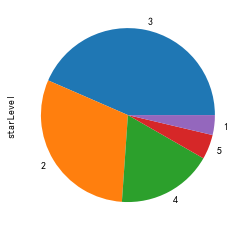

In [27]:
df[df['stars']==6]['starLevel'].value_counts().plot(kind='pie')

In [28]:
df_top106 = df[df['stars']==6].sort_values('rating', ascending=False).head(10)  # 10大六边形战士

datas = {}
for i in range(10):
    sr = df_top106.reset_index().iloc[i]
    name = sr['name'].split('·')[-1]
    value = (sr[['shot', 'speed', 'dribble', 'pass', 'defend', 'physical']]/20).astype(float).round(2).tolist()
    datas[name] = [value]

tl = Timeline()
# 'shot', 'speed', 'dribble', 'pass', 'defend', 'physical'
schema = [opts.RadarIndicatorItem(name=name, max_=5) for name in ('射门', '速度', '盘带', '传球', '防守', '身体')]
for player, data in datas.items():
    radar = Radar().add_schema(schema=schema).add(player, data)
    tl.add(radar, player)
tl.render('六边形战士雷达图.html')

'D:\\JupyterFile\\mytest\\六边形战士雷达图.html'

- 玻璃人巨星

In [29]:
df[df['injuryResistance']==1].sort_values('rating', ascending=False).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel', 'injuryResistance']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel,injuryResistance
2,内马尔·达席尔瓦,27,175,68,南美洲,巴西,法甲,巴黎圣日耳曼,左边锋,92,5,1
25,卡里姆·本泽马,32,185,81,欧洲,法国,西甲,皇家马德里,中锋,89,5,1
30,托尼·克罗斯,29,183,76,欧洲,德国,西甲,皇家马德里,中前卫,88,5,1
31,蒂亚戈·阿尔坎塔拉,28,174,70,欧洲,西班牙,其他欧洲球队,拜仁慕尼黑,中前卫,88,5,1
47,拉斐尔·瓦拉内,26,191,81,欧洲,法国,西甲,皇家马德里,中后卫,87,5,1
49,蒂博·库尔图瓦,27,199,96,欧洲,比利时,西甲,皇家马德里,守门员,87,5,1
51,马尔科·罗伊斯,30,180,71,欧洲,德国,任意球员,自由球员,前腰,87,5,1
54,加雷思·贝尔,30,185,82,欧洲,威尔士,西甲,皇家马德里,右边锋,87,5,1
57,马尔科·维拉蒂,27,165,60,欧洲,意大利,法甲,巴黎圣日耳曼,中前卫,87,5,1
58,约尔迪·阿尔巴,30,170,68,欧洲,西班牙,西甲,巴塞罗那,左后卫,87,5,1


### 三、机器学习实战
- 回归问题：总评分与能力的回归问题
- 被低估的10大球员
- 被高估的10大球员

注：每次运行结果可能不一致

In [35]:
X = df[['age', 'height', 'weight', 'footId', 'offensiveAwareness', 'finishing', 'header', 'aggression', 'speed',
       'ballControl', 'lowPass', 'catching', 'dribbling', 'placeKicking',
       'loftedPass', 'acceleration', 'kickingPower', 'defensiveAwareness',
       'ballWinning', 'clearing', 'gkAwareness', 'reflexes', 'stamina',
       'balance', 'jump', 'reach', 'injuryResistance', 'physicalContact']].values
yr = df['rating'].values  # 回归任务：评分
ys = df['starLevel'].values  # 第一类分类任务：星级
lepl = LabelEncoder()
ypl = lepl.fit_transform(df['posLevel'])  # 第二类分类任务：区分前场、中场、后场、门将 4类球员

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, yr)
rfr = RandomForestRegressor().fit(X_train, y_train)
rfr.score(X_test, y_test)

0.9579283633669066

In [37]:
df['ratingPred'] = rfr.predict(X)
df['Drating'] = df['ratingPred'] - df['rating']

In [38]:
df.sort_values('Drating', ascending=False).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'ratingPred', 'Drating']]

,name,age,height,weight,region,nation,league,team,position,rating,ratingPred,Drating
14364,尤斯廷·哈贝尔,38,180,76,欧洲,马耳他,任意球员,自由球员,守门员,58,64.06,6.06
4340,彼得·哈林,26,187,85,欧洲,奥地利,Ladbrokes Premiership,哈茨,后腰,72,76.97,4.97
14612,雅各布·瑟伦森,24,180,78,欧洲,丹麦,3F Superliga,霍尔森斯,中锋,57,61.96,4.96
6801,里基·拉米,26,188,85,欧洲,苏格兰,Ladbrokes Premiership,利文斯顿,左后卫,69,73.93,4.93
13004,巴巴卡尔·迪奥内,22,167,70,欧洲,比利时,Jupiler Pro League,穆斯克龙精英,左前卫,61,65.49,4.49
5812,德拉甘·切兰,32,190,78,欧洲,塞尔维亚,AFC Champions League,塔什干棉农,影锋,70,74.48,4.48
6826,阿兰·索萨,22,172,66,南美洲,巴西,Jupiler Pro League,圣图尔登,中锋,69,73.42,4.42
13433,斯特凡诺·吉雷利,18,180,78,欧洲,意大利,Italian 2nd Division,克雷莫内塞,中前卫,60,64.22,4.22
4462,阿姆鲁·瓦尔达,26,176,70,非洲,埃及,任意球员,自由球员,左边锋,72,76.20,4.20
12071,奥斯瓦尔·阿尔瓦雷斯,24,178,78,南美洲,哥伦比亚,Liga Aguila,博亚卡 红白&绿,中锋,63,67.18,4.18


In [39]:
df.sort_values('Drating', ascending=True).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'ratingPred', 'Drating']]

,name,age,height,weight,region,nation,league,team,position,rating,ratingPred,Drating
24,埃德森·莫赖斯,26,188,86,南美洲,巴西,英超,曼城,守门员,89,70.45,-18.55
2234,塞瓦斯蒂安·比埃拉,36,184,86,南美洲,乌拉圭,Liga Aguila,巴兰基亚 红白,守门员,76,69.14,-6.86
80,蒂亚戈·席尔瓦,35,183,79,南美洲,巴西,法甲,巴黎圣日耳曼,中后卫,86,79.22,-6.78
98,詹路易吉·唐纳鲁马,20,196,76,欧洲,意大利,意甲,AC米兰,守门员,85,78.56,-6.44
428,尼科·舒尔茨,26,180,78,欧洲,德国,任意球员,自由球员,左后卫,81,75.45,-5.55
43,毛罗·伊卡尔迪,26,181,75,南美洲,阿根廷,法甲,巴黎圣日耳曼,中锋,87,81.74,-5.26
414,卢卡斯·克洛斯特曼,23,189,83,欧洲,德国,任意球员,自由球员,右后卫,81,75.85,-5.15
365,萨利夫·萨内,29,196,85,非洲,塞内加尔,其他欧洲球队,沙尔克04,中后卫,82,77.08,-4.92
3,维吉尔·范迪克,28,193,92,欧洲,荷兰,英超,利物浦 红,中后卫,91,86.30,-4.70
2495,乌奈·西蒙,22,190,89,欧洲,西班牙,西甲,毕尔巴鄂 红白,守门员,75,70.38,-4.62


- 分类问题：各项能力与星级分类

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, ys)
rfcs = RandomForestClassifier().fit(X_train, y_train)
rfcs.score(X_test, y_test)

0.8863757317722193

In [47]:
df['starPred'] = rfcs.predict(X)
df['Dstar'] = df['starPred'] - df['starLevel']

In [48]:
df.sort_values(['Dstar', 'rating'], ascending=[True, False]).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'starLevel', 'starPred', 'Dstar']]

,name,age,height,weight,region,nation,league,team,position,starLevel,starPred,Dstar
120,索克拉蒂斯·帕帕斯塔索普洛斯,31,186,89,欧洲,希腊,英超,阿森纳,中后卫,5,3,-2
24,埃德森·莫赖斯,26,188,86,南美洲,巴西,英超,曼城,守门员,5,4,-1
28,皮埃尔-埃梅里克·奥巴梅扬,30,187,80,非洲,GABON,英超,阿森纳,中锋,5,4,-1
30,托尼·克罗斯,29,183,76,欧洲,德国,西甲,皇家马德里,中前卫,5,4,-1
40,萨乌尔·尼格斯,25,184,77,欧洲,西班牙,西甲,马德里竞技,中前卫,5,4,-1
56,卡塞米罗,27,185,84,南美洲,巴西,西甲,皇家马德里,后腰,5,4,-1
64,奥斯曼·登贝莱,22,178,67,欧洲,法国,西甲,巴塞罗那,左边锋,5,4,-1
71,哈基姆·齐耶赫,26,183,68,非洲,摩洛哥,Eredivisie,阿贾克斯,前腰,5,4,-1
76,马泰斯·德里赫特,20,188,89,欧洲,荷兰,意甲,尤文图斯,中后卫,5,4,-1
79,勒鲁瓦·萨内,23,183,75,欧洲,德国,英超,曼城,左边锋,5,4,-1


In [49]:
df.sort_values(['Dstar', 'rating'], ascending=[False, False]).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'starLevel', 'starPred', 'Dstar']]

,name,age,height,weight,region,nation,league,team,position,starLevel,starPred,Dstar
777,罗克·梅萨,30,172,74,欧洲,西班牙,西甲,莱加内斯 蓝白,中前卫,3,4,1
912,马雷克·苏希,31,183,84,欧洲,捷克,任意球员,自由球员,中后卫,3,4,1
1029,安东尼奥·普埃尔塔斯,27,183,77,欧洲,西班牙,西甲,格拉纳达 红白,右边锋,3,4,1
2985,诺纳托,21,174,68,南美洲,巴西,巴西足球甲级联赛,巴西国际,中前卫,2,3,1
2989,居文·亚尔琴,20,184,77,欧洲,土耳其,Spor Toto Süper Lig,贝西克塔斯,中锋,2,3,1
2996,亚卡·比约尔,20,190,85,欧洲,斯洛文尼亚,俄罗斯超级联赛,莫斯科中央陆军,后腰,2,3,1
3040,哈德尔·奥夫里安,24,166,66,南美洲,哥伦比亚,Liga Aguila,里奥内格罗 红黄,前腰,2,3,1
3061,萨利姆·阿马拉,23,184,74,欧洲,比利时,Jupiler Pro League,标准列日,前腰,2,3,1
3066,雅辛·阿德利,19,186,78,欧洲,法国,法甲,波尔多,前腰,2,3,1
3105,马哈茂德·詹内什,32,188,80,非洲,埃及,任意球员,自由球员,守门员,2,3,1


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, ypl)
rfcp = RandomForestClassifier().fit(X_train, y_train)
rfcp.score(X_test, y_test)

0.9004789781798829

In [51]:
df_cm = pd.DataFrame(confusion_matrix(ypl, rfcp.predict(X)))
df_cm.columns = lepl.classes_
df_cm.index = lepl.classes_
df_cm

,中场,前场,后场,门将
中场,4640,97,112,0
前场,79,3454,2,0
后场,81,3,4797,0
门将,0,0,0,1766


In [52]:
df['posLPred'] = lepl.inverse_transform(rfcp.predict(X))

In [53]:
df[df['posLevel']!=df['posLPred']].sort_values('rating', ascending=False).head(10)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'rating', 'starLevel', 'position', 'posLevel', 'posLPred']]

,name,age,height,weight,region,nation,league,team,rating,starLevel,position,posLevel,posLPred
14,塞尔吉奥·拉莫斯,33,184,82,欧洲,西班牙,西甲,皇家马德里,90,5,中后卫,后场,中场
91,戴维·阿拉巴,27,180,76,欧洲,奥地利,其他欧洲球队,拜仁慕尼黑,86,5,左后卫,后场,中场
94,米克尔·奥亚尔萨瓦尔,22,181,78,欧洲,西班牙,西甲,巴斯科希普斯夸 蓝白,85,5,左边锋,前场,中场
110,弗洛里安·托万,26,179,70,欧洲,法国,法甲,马赛,85,5,右前卫,中场,前场
123,塞萨尔·阿斯皮利奎塔,30,178,78,欧洲,西班牙,英超,切尔西 蓝,85,5,右后卫,后场,中场
130,大卫·路易斯,32,189,84,南美洲,巴西,英超,阿森纳,85,5,中后卫,后场,中场
227,乔治亚·德阿拉斯凯塔,25,172,70,南美洲,乌拉圭,巴西足球甲级联赛,弗拉门戈,83,4,前腰,中场,前场
266,费利佩·安德森,26,175,69,南美洲,巴西,英超,西汉姆 红蓝,83,4,左前卫,中场,前场
273,杜杜,27,166,63,南美洲,巴西,巴西足球甲级联赛,帕尔梅拉斯,83,4,右前卫,中场,前场
375,马科斯·阿隆索,29,188,84,欧洲,西班牙,英超,切尔西 蓝,82,4,左后卫,后场,中场


- 聚类问题：武磊到底属于什么水平，和C罗有多大差距

In [54]:
df_lw = df.query('position=="左边锋"')
X = df_lw[['age', 'height', 'weight', 'footId', 'offensiveAwareness', 'finishing', 'header', 'aggression', 'speed',
       'ballControl', 'lowPass', 'catching', 'dribbling', 'placeKicking',
       'loftedPass', 'acceleration', 'kickingPower', 'defensiveAwareness',
       'ballWinning', 'clearing', 'gkAwareness', 'reflexes', 'stamina',
       'balance', 'jump', 'reach', 'injuryResistance', 'physicalContact']].values
X_cluster = MinMaxScaler().fit_transform(X)

In [55]:
X_cluster.shape  # 709名左边锋，28个特征

(709, 28)

In [56]:
Ks = range(5, 31, 2)
scores = []
for K in Ks:
    labels = KMeans(n_clusters=K).fit_predict(X_cluster)
    scores.append(silhouette_score(X_cluster, labels))

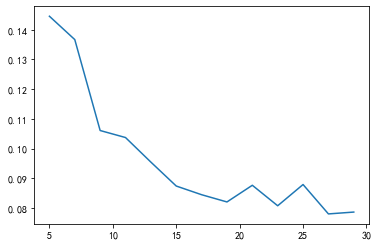

In [57]:
plt.plot(Ks, scores)

In [58]:
labels = KMeans(n_clusters=5).fit_predict(X_cluster)

In [59]:
df_lw['cluster'] = labels

df_lw.query('name=="武磊"')

c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,age,height,weight,footId,region,nation,league,team,position,...,physical,defend,shot,stars,ratingPred,Drating,starPred,Dstar,posLPred,cluster
1443,武磊,28,174,66,1,亚洲及大洋洲,中国,西甲,略夫雷加特 蓝白,左边锋,...,61.4,50.0,72.0,5,76.22,-0.78,3,0,前场,0


In [60]:
df_lw.groupby(by=labels)['rating'].mean()

0    72.455446
1    73.365854
2    64.072650
3    79.123894
4    64.346154
Name: rating, dtype: float64

Text(64.4, 4, '64.3')

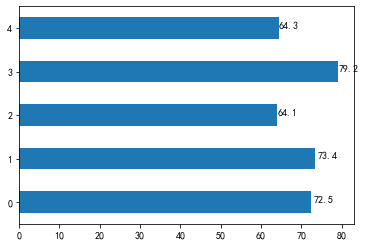

In [62]:
df_lw.groupby(by=labels)['rating'].mean().plot(kind='barh')
plt.text(73, 0, '72.5')
plt.text(74, 1, '73.4')
plt.text(64.1, 2, '64.1')
plt.text(79.2, 3, '79.2')
plt.text(64.4, 4, '64.3')

In [64]:
df_lw.query('cluster==0').sort_values('rating', ascending=False).head(12)[['name', 'age', 'height', 'weight', 'region', 'nation', 'league', 'team', 'position', 'rating', 'starLevel']]

,name,age,height,weight,region,nation,league,team,position,rating,starLevel
320,昆西·普罗梅斯,27,174,71,欧洲,荷兰,Eredivisie,阿贾克斯,左边锋,82,4
523,瑞恩·巴贝尔,33,185,84,欧洲,荷兰,Eredivisie,阿贾克斯,左边锋,81,4
708,路易斯·迪亚斯,22,180,73,南美洲,哥伦比亚,Liga NOS,波尔图,左边锋,79,3
753,迪奥戈·若塔,23,178,70,欧洲,葡萄牙,英超,沃尔弗汉普顿 黑黄,左边锋,79,3
978,布拉德利·赫德森-奥多伊,19,182,79,欧洲,英格兰,英超,切尔西 蓝,左边锋,78,3
1019,奥萨马·伊德里西,23,183,78,非洲,摩洛哥,Eredivisie,阿尔克马尔,左边锋,78,3
1043,塞西略·多明格斯,25,178,70,南美洲,巴拉圭,Superliga Argentina,阿根廷独立,左边锋,78,3
1487,米斯拉夫·奥尔西奇,27,179,69,欧洲,克罗地亚,其他欧洲球队,萨格勒布迪纳摩,左边锋,77,3
1641,法比奥·博里尼,28,180,74,欧洲,意大利,意甲,维罗纳,左边锋,77,3
1597,罗梅尔·基奥托,28,180,78,北美洲和中美洲,洪都拉斯,任意球员,自由球员,左边锋,77,3


In [65]:
df_lw5 = df.query('((position=="左边锋")&(starLevel==5)|(name=="武磊"))')[['name', 'speed', 'finishing']]

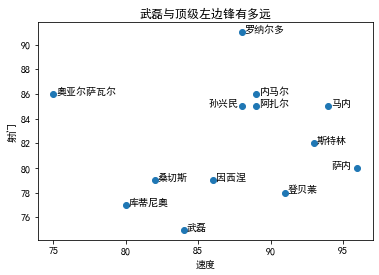

In [66]:
lw5 = df_lw5.values
plt.scatter(x=lw5[:, 1].astype(int), y=lw5[:, 2].astype(int))
for name, x, y in zip(lw5[:,0], lw5[:,1].astype(int), lw5[:,2].astype(int)):
    name = name.split('·')[-1]
    x += 0.2
    if name=='孙兴民':
        x -= 2.5
    if name=='萨内':
        x -= 2
    if name=='达席尔瓦':
        name = '内马尔'
    plt.text(x, y, name)
plt.xlabel('速度')
plt.ylabel('射门')
plt.title('武磊与顶级左边锋有多远')
plt.savefig('武磊')